# Nonlinear Elasticity in a multipatch domain


In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

# line search
from scipy.optimize import line_search

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# 3 D #
p = 3  # spline degree 
n_el = (5, 2, 1)  # number of elements in x, y, z direction, isotropic material
# displacement space: degree p,   continuity p-1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=1) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)


In [3]:
m_u

(8, 5, 4)

In [4]:
N = np.prod(tuple(kv.numdofs for kv in kvs_u))
print(N)
print(shape(m_u))

160
(3,)


In [5]:
def grid_eval(f, grid):
    """Evaluate function `f` over the tensor grid `grid`."""
    if hasattr(f, 'grid_eval'):
        return f.grid_eval(grid)
    else:
        mesh = np.meshgrid(*grid, sparse=True, indexing='ijk')
        mesh.reverse() # convert order ZYX into XYZ
        values = f(*mesh)
        return _ensure_grid_shape(values, grid)

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from mpl_toolkits import mplot3d

def plot_geo(geo,
             grid=10, gridx=None, gridy=None, gridz= None,
             res=50,
             linewidth=None, color='black',  **kwargs):
    """Plot a wireframe representation of a 2D geometry."""
    #fig = plt.figure()
    
    if geo.sdim == 1 and geo.dim == 2:
        print("plot_curve")
        return plot_curve(geo, res=res, linewidth=linewidth, color=color)
    
    #print("geo.sdim:", geo.sdim)
    #print("geo.dim:", geo.dim)
    
    if geo.dim == geo.sdim == 2:
        #assert geo.dim == geo.sdim == 2, 'Can only plot 2D geometries'
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        supp = geo.support

        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        meshy = np.linspace(supp[1][0], supp[1][1], res)

        def plotline(pts, capstyle='butt'):
            plt.plot(pts[:, 0], pts[:, 1], color=color, linewidth=linewidth,
                     solid_joinstyle='round', solid_capstyle=capstyle)

        pts = grid_eval(geo, (gridx, meshy))
        plotline(pts[0, :, :], capstyle='round')
        for i in range(1, pts.shape[0] - 1):
            plotline(pts[i, :, :])
        plotline(pts[-1, :, :], capstyle='round')

        pts = grid_eval(geo, (meshx, gridy))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

    
    if geo.sdim == geo.dim == 3:
        #print("3D geometry")
        # syntax for 3-D projection
        #ax = plt.axes(projection ='3d')
        #assert geo.dim == geo.sdim == 3, 'Can only plot 3D geometries'
        
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
            #print(gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        #print(meshx)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotline(pts, capstyle='butt'):
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], cmap=cm.coolwarm, linewidth=linewidth,  **kwargs)

        pts = grid_eval(geo, (gridx, meshy, meshz))# meshy
        plotline(pts[0, :, :], capstyle='round')# beginning
        for i in range(1, pts.shape[0] - 1): 
            plotline(pts[i, :, :]) # inbetween
        plotline(pts[-1, :, :], capstyle='round') # end

        pts = grid_eval(geo, (meshx, gridy, meshz))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

        pts = grid_eval(geo, (meshx, meshy, gridz))
        plotline(pts[:, :, 0], capstyle='round')
        for k in range(1, pts.shape[2] - 1): 
            plotline(pts[:, :, k])
        plotline(pts[:, :, -1], capstyle='round')

        # plotting
        #ax.set_title('3D line plot')
        #plt.show()


In [7]:
geo = geometry.unit_square()

In [8]:
geo = geometry.unit_cube()


In [9]:
geo = geometry.twisted_box()

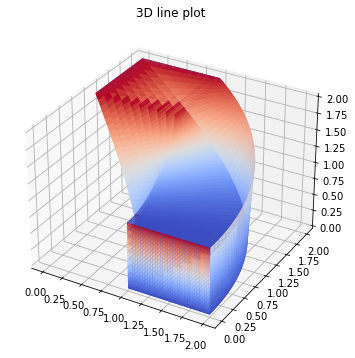

In [10]:
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')

plot_geo(geo)
#axis('scaled');
ax.set_title('3D line plot')
plt.show()

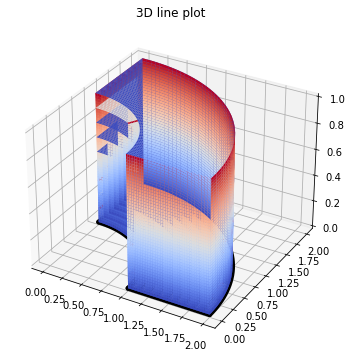

In [11]:
#G = geometry.tensor_product(geometry.quarter_annulus(), geometry.line_segment(0,2))
G2 =  geometry.quarter_annulus()
G = geometry.tensor_product(geometry.line_segment(0,1), geometry.quarter_annulus())
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')
plot_geo(G) #vmin=0.0, vmax=2.5e-2 3D

plot_geo(G2, linewidth=5) #vmin=0.0, vmax=2.5e-2 2D
ax.set_title('3D line plot')
plt.show()

In [12]:
# define geometry
# realistic model of an artery: r_inner= 4mm, r_outer= 7mm (preprint)
# human carotid artery: r_i= 3.1 mm, r_o= 4mm (Holzapfel)
r_out = 0.4
r_in = 0.31

geos = [
 
    geometry.quarter_annulus(r1=r_in, r2=r_out),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(3*pi/2),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi/2)
]


# 3D
#geos_3d = [geometry.tensor_product(geometry.line_segment(0,2), g) for g in geos]
geos_3d = [geometry.tensor_product(g, geometry.line_segment(0,1)) for g in geos]

In [13]:
patches_u = [(kvs_u, g) for g in geos_3d] # 3D

# Here we auto-detect the interfaces between the patches.
MP_u = assemble.Multipatch(patches_u, automatch=True) #3D

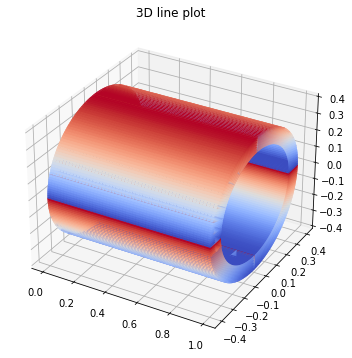

In [14]:
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')

for g in geos_3d:
    plot_geo(g)#, vmin=0, vmax=7.5)

ax.set_title('3D line plot')
plt.show()

In [15]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch , 2D only!
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator
import numpy as np


def get_defplot(u, patches_u, kvs_u, grid=10, gridx=None, gridy=None, gridz= None,
             res=30, linewidth=None, color='black',  **kwargs):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    
    figsize(10,10)
    #fig, ax = plt.subplots()
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx) # e.g. linespace(0, 1, 10)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)
  
    # 3D surface plot  
    
    # Create an empty array of strings with the same shape as the meshgrid, and
# populate it with two colors in a checkerboard pattern.
        xlen = len(meshx)
        ylen = len(meshy)
        X, Y = np.meshgrid(meshx, meshy)
        colortuple = ('y', 'b')
        colors = np.empty(X.shape, dtype=str)
        for y in range(ylen):
            for x in range(xlen):
                colors[y, x] = colortuple[(x + y) % len(colortuple)]
                
        def plotline(pts, capstyle='butt'):
            #ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], cmap='afmhot' , linewidth=linewidth, **kwargs)
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], facecolors=colors, linewidth=0)
            #cmap=cm.coolwarm, 'summer'

        xgridyz = (gridx , meshy, meshz)
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # x-grid
        dis1 = u1_func.grid_eval(xgridyz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(xgridyz) #y-value
        dis3 = u3_func.grid_eval(xgridyz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
        #print(shape(dis))
        #print('dis=', dis)
  
        pts = grid_eval(geo, xgridyz) + dis  # + displacement x-coord
        plotline(pts[0, :, :], capstyle='round')# beginning
        for i in range(1, pts.shape[0] - 1): 
            plotline(pts[i, :, :])               # inbetween
        plotline(pts[-1, :, :], capstyle='round') # end
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid

        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')
        
        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
        
        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        #pts =  G[..., 2] + displ[..., 2]
        plotline(pts[:, :, 0], capstyle='round')
        for k in range(1, pts.shape[2] - 1): 
            plotline(pts[:, :, k])
        plotline(pts[:, :, -1], capstyle='round')


    #plot_deformation(dis, res, geo, ax, vmin=0.0, vmax=1.5e-4)
    potential = J(u)
    #colorbar();
    # Set up colorbar
    #sm = plt.cm.ScalarMappable(cmap='afmhot')
    #sm.set_array(potential)
    #fig.colorbar(sm, shrink=0.5, aspect=5)

    #axis('auto')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    plt.show()


In [16]:
class multipatch_block_handler:
    
    # Takes array of multi-patch objects
    def __init__( self, multi_patches ):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X,multi_patch.patch_to_global(p)))
        return X
    
    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                if len(item)<4 or p in item[3]:
                    data_p.append( (item[0], item[1], lambda *x : item[2](*x)[p]) )
            if len(data_p)>0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    #Indices need offset
                    bcs[0] = numpy.concatenate((bcs[0],bcs_p[0]+offset))
                    #Values are kept as-is
                    bcs[1] = numpy.concatenate((bcs[1],bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)
    
    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset


In [17]:
# define boundary conditions

In [167]:
# source term f, 3D
def f(x, y, z): return (0.0, 0.0, 0.0)

In [168]:
#Neumann BC
#def gN(x, y): return (x, -y)  #outer pressure
# 3D
#def gN(x, y, z): 
#    return (x/0.31*loading_value, y/0.31*loading_value, z/0.31*loading_value)  #inner  pressure, normalized vector

def gN(x, y, z): 
#quarter annulus in y/z coord.system
    return (0, y/r_in*loading_value, z/r_in*loading_value) # inner pressure
# quarter annulus in x/x coord.system
    #return (x/r_out*loading_value, y/r_out*loading_value, 0)  #inner  pressure, normalized vector
# normal direction in z does not exist by now!

#incremental loading
loading = [5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4] #, 1.25e-4] 
#loading = [5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3]  

# set loading_value (used in 1st iteration, lin. problem)
loading_value = loading[-1]
#loading_value =  1e-3

neu_data = [(0,'bottom',gN), (1,'bottom',gN), (2,'bottom',gN), (3,'bottom',gN)] 
#neu_data = [] # no neumann bd cond.

In [169]:
# Multipatch objects for all variables (x, y, z)
MP_block = multipatch_block_handler( [MP_u, MP_u, MP_u] ) 

In [170]:
# define Dirichlet boundary function 
def g_zero(x, y, z): return (0.0, 0.0, 0.0) # fixed in y/z, x runs, evtl. set x=x

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'top', g_zero ) # outer bd, 1
])

In [171]:
# Compute solution of nonlinear elasticity problem

In [172]:
#split the solution into its components (displacement in x- and y- direction) and convert to BSpline function
def get_components(u, kvs_u):
    """Split solution vector into displacement components."""
    #print("shape_u", shape(u))
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)          
    u2 = u[N:2*N].reshape(m_u)    
    u3 = u[2*N:3*N].reshape(m_u)    
    U = np.stack((u1,u2,u3), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)


In [173]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)
# incompressible: Lam = 0


# nonlinear variational form
def apply_nl(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    z_lam = Lam* assemble.assemble('div(dis)*div(v) * dx+ 1/2 *tr( grad(dis).T *grad(dis)) *div(v)*dx + inner(div(dis)*grad(dis), grad(v))*dx + inner(1/2 * tr(grad(dis).T *grad(dis))*grad(dis), grad(v)) *dx'
                             , kvs_ux, bfuns=[('v',3)], geo=geo_ux, dis=dis)
    z_mu = Mu* assemble.assemble('inner(grad(dis).T +grad(dis) + grad(dis).T *grad(dis), grad(v))*dx + inner(grad(dis)*(grad(dis).T +grad(dis) + grad(dis).T*grad(dis)), grad(v)) *dx'
                                    , kvs_ux, bfuns=[('v',3)], geo=geo_ux, dis=dis)
    return (z_lam + z_mu).ravel()  # vector z

# linearized variational form
def linearized(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    A_lin_lam = Lam* assemble.assemble('(inner( (div(dis) + 1/2 *tr( grad(dis).T *grad(dis) )) * grad(u), grad(v)) + div(u)*div(v) + tr( grad(dis).T *grad(u) ) * div(v) + inner( (div(u) + tr(grad(dis).T *grad(u)) ) * grad(dis), grad(v)) ) * dx'
                              , kvs_ux, bfuns=[('u',3), ('v',3)], geo=geo_ux, dis=dis) #matrix A_lam
    
    A_lin_mu = 2*Mu * assemble.assemble('(inner(1/2 * grad(u)*(grad(dis)+ grad(dis).T + grad(dis).T *grad(dis)) + (1/2) * (grad(u)+grad(u).T + grad(dis).T *grad(u) + grad(u).T *grad(dis)) + 1/2 * grad(dis)*(grad(u)+grad(u).T +grad(dis).T * grad(u)+ grad(u).T * grad(dis)), grad(v))) * dx'
                              , kvs_ux, bfuns=[('u',3), ('v',3)], geo=geo_ux, dis=dis) #matrix A_mu
    
    return A_lin_lam + A_lin_mu # matrix A



In [174]:
# assemble matrix A and rhs b for nonlinear elasticity problem
def ass_nonlinsystem(u, neu_data):
    first = True
    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        #kvs_uy, geo_uy = MP_block.multi_patches[1].patches[p]
        #kvs_uz, geo_uz = MP_block.multi_patches[2].patches[p] # same as x

        # The whole patch-local stiffness matrix
        A_p = linearized(u, kvs_ux, geo_ux, X) # take linearized variatonal form

        # The patch-local right-hand side
        b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() - apply_nl(u, kvs_ux, geo_ux, X) # for arbitrary rhs
        
        # The patch-local Neumann boundary data
        
        ##implemented normal vector
        nv = assemble.assemble('inner(v, n) * ds', kvs_ux, bfuns=[('v', 3)], geo=geo_ux, boundary='bottom', layout='packed')
        #print(nv.sum(axis=(0,1,2)))

        for item in neu_data:
            if item[0]==p:
                N_e  = assemble.assemble('inner(g,v)*ds', kvs_ux, geo=geo_ux, g=item[2], bfuns=[('v', 3)], symmetric=True, boundary=item[1] ).ravel()
                #print("N_e", shape(N_e))
                N_e = N_e.reshape(3, -1) # 3dim, -1 remaining factor to get to the total number of elements
                #print("N_e", shape(N_e))
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                len_bdofs = len(bdofs)
                #print('len_bdofs ', len_bdofs )
                for c in range(3):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len_bdofs):
                        b_p[bdofs[i]+offset] += N_e[c,i]  #N_e[c,i,0, 0] #N_e[c,i,0]
      
        if first:
            A = X @ A_p @ X.T
            b = X @ b_p 
            first = False
        else:
            A += X @ A_p @ X.T
            b += X @ b_p 
    
    return A, b

In [175]:
# elasticity problem
#linear problem = linearized problem (for development point x_0=(0...0) )
def grad_J(x): #nonlin function (rhs) # u
    # a(u,v)-l(v)
    u_p = x
    first = True
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        b_p= apply_nl(u_p, kvs_ux, geo_ux, X) #non-linear form a(u,v)

        b0_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() # rhs (0,0,...,0) for nbc

        for item in neu_data:
            if item[0]==p:
                N_e  = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',3)], geo=geo_ux, g=item[2], boundary=item[1]).ravel()
                N_e = N_e.reshape(3, -1)
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(3):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b_p[bdofs[i]+offset] += N_e[c,i]  #N_e[c,i,0, 0] #N_e[c,i,0]
         
        if first:
            grad_b = X @ (b_p- b0_p)#"Au-b"
            first = False
        else:
            grad_b += X @ (b_p- b0_p) 
            
    return grad_b


# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=1) for n in n_el) # constant basis vector for integration

def J(x): #energy functional, scalar valued
    u_p = x
    j_N = 0
    j = 0
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        dis = get_components(X.T @ u_p, kvs_ux)
        j_lam = Lam/8 * assemble.assemble('tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis))**2 *v*dx'
                             , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_mu = Mu/4 * assemble.assemble('tr((grad(dis).T *grad(dis) +grad(dis).T +grad(dis))*(grad(dis).T *grad(dis) +grad(dis).T +grad(dis))) *v*dx'
                                    , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_p = sum(j_lam + j_mu)
        
        for item in neu_data:
            if item[0]==p:
                N_e  = assemble.assemble('inner(g,dis) *v *ds', kvs_j, bfuns=[('v',1)], geo=geo_ux, g=item[2], boundary=item[1], dis=dis) 
                #print('N=',N_e)
                j_N += N_e.sum()

        j += (j_p - j_N)
        
    return j


In [176]:
def Wolfe_LineSearch(f, f_grad, xk, pk):
    # Wolfe-Powell_Line search
    print('Start line search')
    
    mu1 = 0.01
    sigma = 0.9
    tau = 0.1
    tau1 = 0.3
    tau2 = 0.9
    gsi1 = 1
    gsi2 = 10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    alpha_R = None
    phi_L = phi(0)
    derphi_L = derphi(0)
    alphainf= True
    alpha =1 
    phi_min = -1.e2
    eps0 = 1.e-6
    max_iter = 5
    n_iter = 0
    
    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1
        if alpha > 1: # alpha too big # alpha in(0,1)!
            print('alpha >1')
            alpha_R = alpha
            alpha= alpha_L + tau1*(alpha_R - alpha_L)
        else:
            #print('a=', alpha)
            phi_hat= phi(alpha)
            if phi_hat < phi_min: # function unbounded to the bottom
                return alpha 

            if phi_hat > phi(0) + mu1*alpha*derphi(0): #alpha too big # 
                print('  phi_hat=', phi_hat)
                print('  phi_0=', phi(0))
                print('  derphi_0=', derphi(0))
                if derphi(0) >= 0:
                    print('  no descent direction')
                
                alphainf= False
                alpha_R = alpha
                delta = alpha_R - alpha_L
               # print('  delta=', delta)
                ## interpolation
                c = (phi_hat - phi_L - derphi_L*delta)/delta**2
                alpha_tilde = alpha_L - derphi_L/(2*c)
                alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
                print('alpha_int=', alpha)
            
            else: # alpha too small & not too big
                derphi_hat = derphi(alpha)
                if derphi_hat < sigma*derphi(0): # alpha too small
                    print('  alpha too small')
                    if alphainf: # true, alpha_R =inf
                        print('  alpha_R = inf')
                        if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                            alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                        else:
                            alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                    else: # alpha_R < inf
                        print('  alpha_R < inf')
                        if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                            alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                        else:
                            alpha_tilde = alpha + tau2*(alpha_R - alpha)
                    ## update
                    alpha_L = alpha
                    phi_L = phi_hat
                    derphi_L = derphi_hat
                    alpha = alpha_tilde
                
                else:
                    return alpha

      

In [177]:
def make_solver_orig(B, symmetric=False, spd=False):
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    if spd:
        symmetric = True
# Gauß'sche Eliminationsverfahren - LU Zerlegung (auch LR für left-right)
    if scipy.sparse.issparse(B):
        print('use SuperLU')
            # use SuperLU (unless scipy uses UMFPACK?) -- really slow!
        spLU = scipy.sparse.linalg.splu(B.tocsc(), permc_spec='NATURAL')
        M= scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=spLU.solve, matmat=spLU.solve)
        return M
# Cholesky Zerlegung: Matrix muss symmetrisch und positiv definit sein!                  
    else:
        if symmetric:
            print('use Cholesky')
            chol = scipy.linalg.cho_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)
        else:
            print('Matrix is not symmetric')
            LU = scipy.linalg.lu_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.lu_solve(LU, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)
   

In [178]:
def make_solver(matrix):
    B= matrix.todense()
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    
    chol = scipy.linalg.cho_factor(B, check_finite=False) # for s. p.d matrix
    solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
    return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=solve, matmat=solve)
       

In [179]:
def solve(matrix, vector):
    try:
        return make_solver(matrix).dot(vector)
    # cholesky --> takes spd matrix
    except LinAlgError:
        print('use Gradient direction') # matrix not positive definite
        return vector
        #return 10000*vector
        

In [180]:
# solve linearized system 
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)

# set Neumann boundary force (via incremental loading) 
#neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 
    
### first iteration ###
A, b= ass_nonlinsystem(u, neu_data)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
r0= np.linalg.norm(LS.b) # rhs of undeformed system
print('r0=', r0)

u_d = make_solver_orig(LS.A).dot(LS.b) 
u_d = LS.complete(u_d)
u += u_d

A, b= ass_nonlinsystem(u, neu_data)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

###-----------------###--------------------###
# solution = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))
###----------------###---------------------###

r0= 1.9119681404625275e-05
use SuperLU
residual =  2.679904472175834e-06


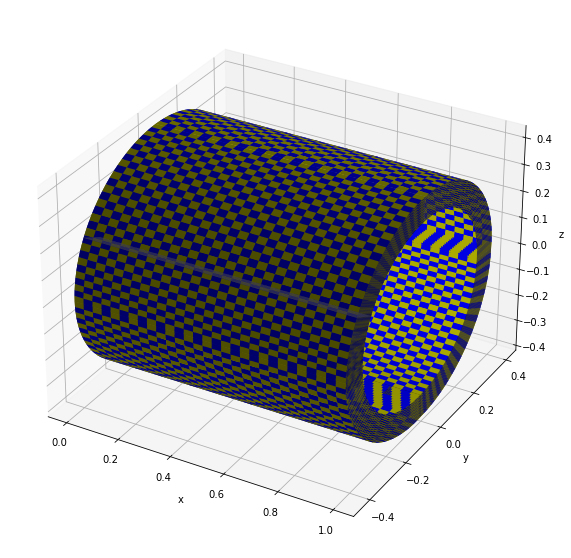

In [181]:
# print deformation plot
get_defplot(u, patches_u, kvs_u)

 
 
 1. loading: 5e-05 

1
use SuperLU
8.667663708945897e-07
Start line search
  0. alpha between 0 and None
  phi_hat= -1.3968675824420538e-06
  phi_0= -2.231286979590553e-06
  derphi_0= -2.4738579817442617e-06
alpha_int= 0.37388914205438106
  1. alpha between 0 and 1
  phi_hat= -1.9883060100220712e-06
  phi_0= -2.231286979590553e-06
  derphi_0= -2.4738579817442617e-06
alpha_int= 0.14805183912328196
  2. alpha between 0 and 0.37388914205438106
  phi_hat= -2.1450999305232914e-06
  phi_0= -2.231286979590553e-06
  derphi_0= -2.4738579817442617e-06
alpha_int= 0.05992463076267555
  3. alpha between 0 and 0.14805183912328196
  phi_hat= -2.1979963961507084e-06
  phi_0= -2.231286979590553e-06
  derphi_0= -2.4738579817442617e-06
alpha_int= 0.02446772970364325
  4. alpha between 0 and 0.05992463076267555
  phi_hat= -2.2179566701777384e-06
  phi_0= -2.231286979590553e-06
  derphi_0= -2.4738579817442617e-06
alpha_int= 0.0100258874815417
alpha= None
residual =  4.643315027327452e-06
2
use SuperLU


alpha_int= 0.02911196037834684
  3. alpha between 0 and 0.09461724167857559
  phi_hat= -1.4324353369793068e-06
  phi_0= -1.4325564988399539e-06
  derphi_0= -6.6590088468463844e-09
alpha_int= 0.008957487610749475
  4. alpha between 0 and 0.02911196037834684
  phi_hat= -1.4325192193620157e-06
  phi_0= -1.4325564988399539e-06
  derphi_0= -6.6590088468463844e-09
alpha_int= 0.0027561646878708503
alpha= None
residual =  1.8181439928646455e-08
 
 
 2. loading: 6e-05 

1
use SuperLU
3.03628529957973e-08
Start line search
  0. alpha between 0 and None
alpha= 1
residual =  2.468657083650774e-08
2
use SuperLU
1.9811586294257463e-12
Start line search
  0. alpha between 0 and None
  alpha too small
  alpha_R = inf
  1. alpha between 1 and None
alpha >1
  2. alpha between 1 and 11
alpha >1
  3. alpha between 1 and 4.0
alpha >1
  4. alpha between 1 and 1.9
alpha >1
alpha= None
residual =  1.2338740136040248e-08
 
 
 3. loading: 7e-05 

1
use SuperLU
3.071971154219962e-08
Start line search
  0. alpha 

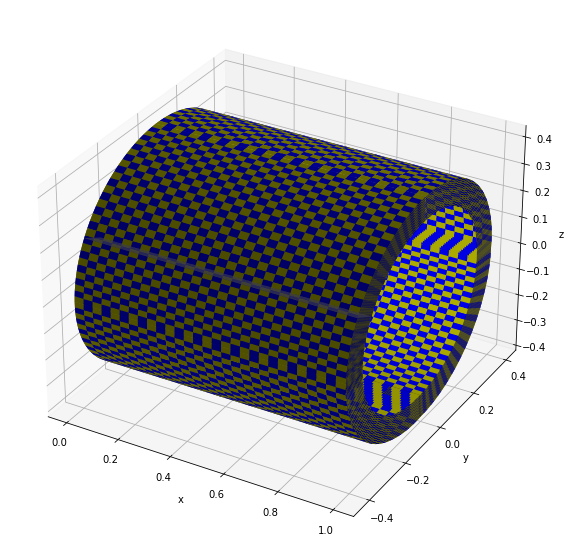

In [182]:
# solve linearized variational problem

epsilon= 1e-3 #1e-6

stepsizes =[] 
ud_array = []

# incremental loading # ----------------------------------
for i in range(len(loading)):
    print(" \n \n {}. loading: {} \n".format(i+1,loading[i]))
    
    # set Neumann data via incremental loading
    loading_value = loading[i]
    #g_N = gN 
    # neu_data = [(0,'right',g_N), (1,'right',g_N), (2,'right',g_N), (3,'right',g_N)] # outer radius
    neu_data = [(0,'bottom',gN), (1,'bottom',gN), (2,'bottom',gN), (3,'bottom',gN)] # inner radius
    
    count= 0
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        A, b= ass_nonlinsystem(u,neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

        # # solve system # #
        #u_d= solvers.make_solver(LS.A).dot(LS.b)
        u_d = make_solver_orig(LS.A).dot(LS.b) 

        # check if matrix is positive definite in a particular direction u_d
        if LS.b.dot(u_d) <= 0:
            print(LS.b.dot(u_d)) #transpose(LS.b)*M*LS.b
            print('Matrix is not positive definit! \n')
        else:
            print(LS.b.dot(u_d))

        # complete system dependent solution
        u_d = LS.complete(u_d)

        # # do Wolfe-Powell line search # # 
        alpha= Wolfe_LineSearch(J, grad_J, u, u_d) 
        #alpha= line_search(J, grad_J, u, u_d) # use integrated line search (scipy)
        print('alpha=', alpha)
        if alpha == None:
            u += 0.5 * u_d # alpha=0.5 (ignore line search)
        else:
            u += alpha * u_d

            
        # compute new non-linear residuum
        A, b = ass_nonlinsystem(u,neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        r = np.linalg.norm(LS.b) # compute residuum
        print('residual = ', r)
        
        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = abs(normed_du0-normed_du)
        stepsizes.append(stepsize_du)
        normed_du0 = normed_du
        #---------------------------------------------------#

        if r < epsilon* r0: # break condition
            break
        elif count == 30:
            break

# print deformation plot
get_defplot(u, patches_u, kvs_u)

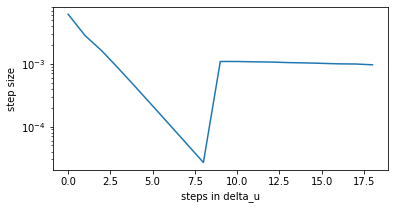

In [183]:
# plot history of step sizes
figsize(6,3)
yscale('log')
plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt



def plot_grid(x, y, ax=None, **kwargs):
    """Plot a grid over a geometry"""
    ax = ax or plt.gca()
    segs1 = np.stack((x, y), axis=3)
    print(shape(segs1[3]))
    segs1 = segs1[3] ## 2-dim
    segs2 = segs1.transpose(1, 0, 2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

# 3D
def plot_grid_3d(x, y, z, ax=None, **kwargs):
    """Plot a grid over a geometry"""
    ax = ax or plt.gca()
    segs1 = np.stack((x, y, z), axis=3)# (2, 2, 2, 3)
    print(shape(segs1[:-2]))
    segs2 = segs1.transpose(1, 2, 0, 3)
    ax.add_collection(LineCollection(segs1[:-2], **kwargs))
    ax.add_collection(LineCollection(segs2[:-2], **kwargs))
    ax.autoscale()

# 3D
def plot_deformation(displ, ref, geo=None, ax=-1, **kwargs):
    """Plot a deformation over a geometry"""
    kwargs.setdefault('shading', 'gouraud')
    #fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    shape_displ = np.shape(displ[ref-1][ref-1][ref-1])[0]
    if geo is not None and shape_displ == 3:
        xgrid = np.linspace(0, 1, ref)
        xyzgrid = (xgrid, xgrid, xgrid)
        G = geo.grid_eval(xyzgrid)
        print(shape(G[..., 0] + displ[..., 0]))

        l2 = np.sqrt(np.power(displ[..., 0], 2) + np.power(displ[..., 1], 2) +np.power(displ[..., 2], 2))
        #plt.pcolormesh(G[..., 0] + displ[..., 0], G[..., 1] + displ[..., 1], l2**2, cmap='summer', **kwargs)
        
        #X, Y, Z = axes3d.get_test_data(0.05)
        #ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
        
        plot_grid(G[..., 0], G[..., 1], ax=ax, color="lightgrey") # undeformed structure
        plot_grid(G[..., 0] + displ[..., 0], G[..., 1] + displ[..., 1], ax=ax, color="black") # deformed structure

        
        X = G[..., 0] + displ[..., 0]
        Y = G[..., 1] + displ[..., 1]
        Z = G[..., 2] + displ[..., 2]
        X_2d = X[3]
        Y_2d = Y[3]
        Z_2d = Z[3]
        print(shape(Z_2d[...,2]))
        
        #plt.pcolormesh(X_2d, Y_2d, l2**2, cmap='summer', **kwargs)
        #surf = ax.plot_surface(X_2d, Y_2d, Z_2d, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        #fig.colorbar(surf, shrink=0.5, aspect=5)
    
 

In [ ]:
# Navier-Stokes

In [ ]:
# Reynolds number
Re = 1e4

# time step
tau = 2e-2

In [ ]:
# assemble Stokes problem
A_grad = assemble.assemble('inner(grad(u), grad(v)) * dx', kvs_u, bfuns=[('u',2), ('v',2)], geo=geo)
A_div  = assemble.assemble('div(u) * p * dx', (kvs_u, kvs_p), bfuns=[('u',2,0), ('p',1,1)], geo=geo)
M_pre = assemble.mass(kvs_p, geo)
M_vel = assemble.mass(kvs_u, geo)

M_vel_full = scipy.sparse.bmat(
    [[M_vel, None, None  ],
     [None, M_vel, None  ],
     [None, None, scipy.sparse.csr_matrix((n_p,n_p))]], format='csr')

A_stokes = scipy.sparse.bmat(
    [[Re**-1*A_grad, A_div.T],
     [A_div,     1e-10*M_pre]], format='csr')

In [ ]:
# compute initial value from Stokes equation
LS = assemble.RestrictedLinearSystem(A_stokes, 0.0, bcs)
u = LS.complete(solvers.make_solver(LS.A).dot(LS.b))
solutions = [LS.restrict(u)]

In [ ]:
# set up nonlinear and linearized N-S system
vel, pre = get_components(u)
print(vel) # B-spline

# nonlinear convection term (functional)
asm_nlconv = assemble.Assembler('grad(vel).dot(vel).dot(v) * dx', kvs_u,
                    bfuns=[('v',2)], geo=geo, vel=vel, updatable=['vel'])
# linearized convection term by freezing velocity (matrix)
asm_linconv = assemble.Assembler('grad(u).dot(vel).dot(v) * dx', kvs_u,
                    bfuns=[('u',2), ('v',2)], geo=geo, vel=vel, updatable=['vel'])

def apply_nl_conv(vel):
    z = asm_nlconv.assemble(vel=vel)
    return np.concatenate((z.ravel(), np.zeros(n_p)))

def apply_navier_stokes(u_p):
    vel, pre = get_components(u_p)
    return apply_nl_conv(vel) + A_stokes.dot(u_p)

def linearized_ns(u_p):
    vel, pre = get_components(u_p)
    A_linconv = asm_linconv.assemble(vel=vel)
    A_lns = scipy.sparse.bmat(
        [[Re**-1*A_grad + A_linconv, A_div.T],
         [A_div,                 1e-10*M_pre]],
        format='csr')
    return A_lns

In [ ]:
# set up DAE for instationary Navier-Stokes
def ns_F(x): #function
    u_p = LS.complete(x)
    return -LS.restrict(apply_navier_stokes(u_p))
def ns_J(x): # Jabobi
    u_p = LS.complete(x)
    return -LS.restrict_matrix(linearized_ns(u_p))
ns_M = LS.restrict_matrix(M_vel_full) # Navier-Stokes mass matrix

# M (matrix): the mass matrix
# F (function): the right-hand side
# J (function): function computing the Jacobian of `F`
# x (vector): the initial value

In [ ]:
F_sol = ns_F(solutions[-1])
print(shape(F_sol))

In [ ]:
t_end = 3.0

time_steps = solvers.rowdaind2(ns_M, ns_F, ns_J, solutions[-1], tau, t_end, tol=1e-2, progress=True)
solutions.extend(time_steps[1][1:])

In [ ]:
# plot history of step sizes
figsize(6,3)
times = array(time_steps[0])
stepsizes = times[1:] - times[:-1]
plot(times[:-1], stepsizes);
xlabel('time'); ylabel('step size');

In [ ]:
T_anim = linspace(0, 3, 200)   # animation timesteps
# interpolate adaptive solution at the animation frame times
sol_interp = scipy.interpolate.interp1d(time_steps[0],
                [LS.complete(uu) for uu in time_steps[1]], axis=0)
fields = [vel_norm(sol_interp(tt)) for tt in T_anim]

In [ ]:
from IPython.display import HTML

figsize(14, 4)
#fields = [vel_norm(LS.complete(uu)) for uu in solutions]
HTML(vis.animate_field(fields, geo, res=(50, 150), vrange=(0,3), interval=35, progress=True).to_html5_video())

In [ ]:
xgrid = linspace(0, 1, 200)
xygrid = (xgrid, xgrid)

velocity, pressure = get_components(LS.complete(solutions[-1]))

In [ ]:
figsize(8,3)
axis('off')
vis.plot_field(pressure, geo);